In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table

import os
from os import getpid

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, Rectangle

from matplotlib.lines import Line2D

import xspec as x

import matplotlib
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from scipy import stats
from scipy.optimize import curve_fit

from tqdm.autonotebook import tqdm

import multiprocessing
import datetime

import scipy.odr as odr

from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from IPython.display import clear_output

/home/aleksei/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/aleksei/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_15087/2343654355.py:29: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
clusters = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\s+', header=0)
clusters = clusters[clusters["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]

wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

clusters

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


ihal     x_pix     y_pix     z_pix      Rrel          Mvir    z_true  \
171     110  0.970969  0.479718  0.014316  0.004703  2.432930e+14  0.157249   
187     163  0.388924  0.570999  0.016006  0.004675  2.390080e+14  0.157312   
350      77  0.380183  0.570491  0.033800  0.005197  3.282700e+14  0.157977   
820      68  0.735543  0.863489  0.086085  0.005228  3.341870e+14  0.159935   
1245    111  0.804864  0.355207  0.133510  0.004668  2.379170e+14  0.161713   
...     ...       ...       ...       ...       ...           ...       ...   
18589   113  0.839159  0.495644  0.394607  0.011199  2.242680e+14  0.063945   
18610   199  0.149218  0.307198  0.406194  0.011455  2.400200e+14  0.064342   
19523   349  0.373303  0.943536  0.987909  0.010375  1.783400e+14  0.084342   
19771   323  0.759637  0.387809  0.508332  0.020783  1.912580e+14  0.034099   
19787    83  0.926032  0.822913  0.526959  0.026050  3.766600e+14  0.034717   

          z_obs          M500     R500      Mstar500       Mgas500     T500  \
171    0.157891  1.366960e+14  688.128  4.470500e+12  1.209540e+13  2.44633   
187    0.159659  1.126680e+14  645.187  2.896080e+12  1.061830e+13  2.43074   
350    0.157810  1.925340e+14  771.351  5.156740e+12  2.121000e+13  3.21771   
820    0.160192  1.800240e+14  754.271  6.340420e+12  1.596800e+13  3.57076   
1245   0.161111  1.321030e+14  680.349  4.667490e+12  9.869480e+12  2.78095   
...         ...           ...      ...           ...           ...      ...   
18589  0.063977  1.184480e+14  615.838  2.883010e+12  1.160680e+13  2.22808   
18610  0.064928  1.282700e+14  632.408  3.427130e+12  1.130680e+13  2.26553   
19523  0.084015  1.055570e+14  592.650  3.313370e+12  6.942770e+12  2.39539   
19771  0.033707  1.272360e+14  616.706  3.593030e+12  1.067760e+13  2.61661   
19787  0.033992  1.682650e+14  676.952  5.699780e+12  1.686950e+13  2.84568   

          Lx500    Ysz500          M200      R200  flag  
171    0.707698  0.000003  2.049620e+14  1068.920     0  
187    0.532571  0.000003  2.049290e+14  1068.880     0  
350    1.515690  0.000005  2.887220e+14  1198.270     0  
820    0.972861  0.000004  2.724390e+14  1175.290     0  
1245   0.452088  0.000003  1.944720e+14  1050.360     0  
...         ...       ...           ...       ...   ...  
18589  0.537683  0.000002  1.889120e+14   976.536     0  
18610  0.455429  0.000002  1.935300e+14   984.440     0  
19523  0.231120  0.000002  1.464050e+14   897.005     0  
19771  0.651073  0.000003  1.638830e+14   910.698     0  
19787  0.951228  0.000004  2.866160e+14  1097.250     0  

[84 rows x 18 columns]

In [7]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\s+', header=2)


binned_clusters = {}
   
for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
    
    for ind in clusters.index:

        zt = clusters.loc[ind]["z_true"]

        if zt > borders[0] and zt < borders[1]:

            binned_clusters[ind] = borders[2], str(borders[3])
                
#sorted(binned_clusters.items())

redshifts = [clusters.loc[i]["z_true"] for i in clusters.index]

geometry

snapNr      ztab    zslice   z_start     z_end          x0          y0  \
0     144  0.001001  0.008625  0.000000  0.017281  230.604600   52.929941   
1     140  0.033671  0.033822  0.017281  0.050478  305.341400  149.855590   
2     136  0.067408  0.067555  0.050478  0.084760   97.871486  134.586170   
3     132  0.102245  0.102388  0.084760  0.120158  185.353850  229.067940   
4     128  0.138220  0.138357  0.120158  0.156713  146.337120  179.784950   
5     124  0.175368  0.175501  0.156713  0.194460  170.716390  187.570430   

           z0       depth       width  
0   38.137176   73.327162   21.167728  
1  172.109480  139.387980   82.573299  
2  117.805860  141.855220  163.761220  
3  294.134880  144.222380  246.344710  
4  264.241690  146.478010  330.262680  
5  175.891600  148.610980  415.447530

### Stacking

/home/aleksei/work/clusters/stacking/scripts.py:506: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1', '10', '100'])
/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1'])


<Figure size 640x480 with 0 Axes>

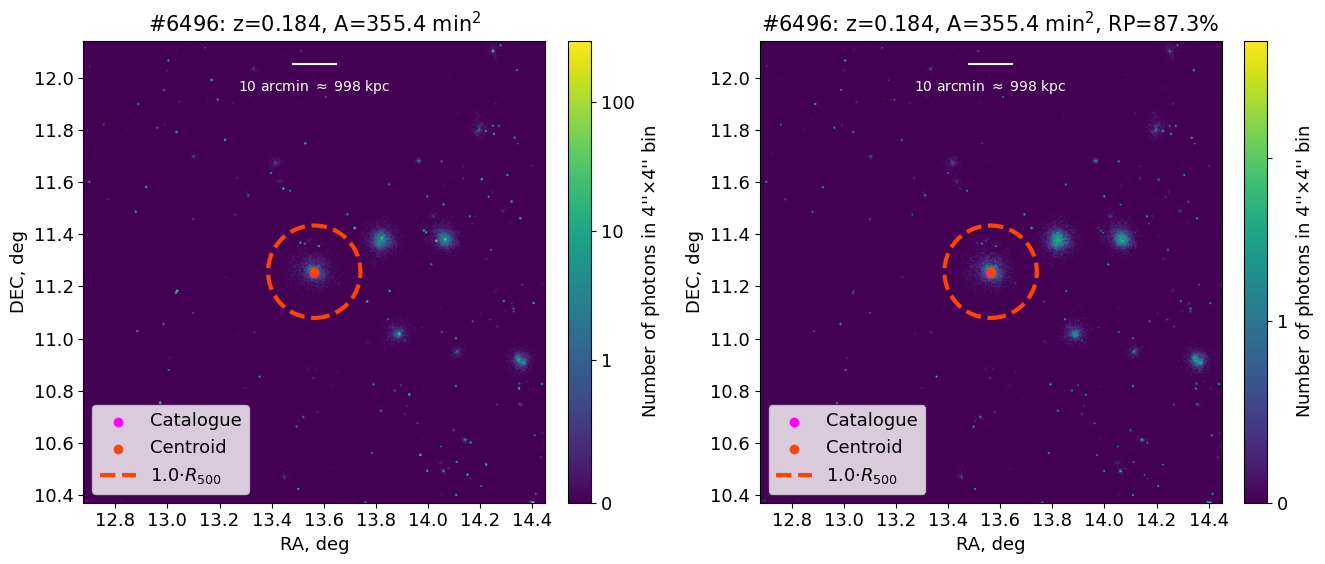

In [17]:
%run -i 'scripts.py'

plt.figure(figsize=(16,6))

cl_num = 6496
RRR = 1.0

plt.subplot(121)
pho_list = extract_photons_from_cluster(cl_num, 
                                        r = RRR, 
                                        centroid=True, 
                                        delete_bright_regions=False, 
                                        draw=True,
                                        draw_additional=False)

plt.subplot(122)
pho_list = extract_photons_from_cluster(cl_num, r = RRR, centroid=True, 
                                        delete_bright_regions=True, draw=True,
                                        draw_additional=False)

#display(pho_list)

plt.show()

/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1'])
/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1'])
/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1'])
/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1'])
/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks,

/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1'])
/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1'])
/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1'])
/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1'])
/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks,

/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1'])
/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1'])
/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1'])
/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1'])
/home/aleksei/work/clusters/stacking/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks,

<Figure size 640x480 with 0 Axes>

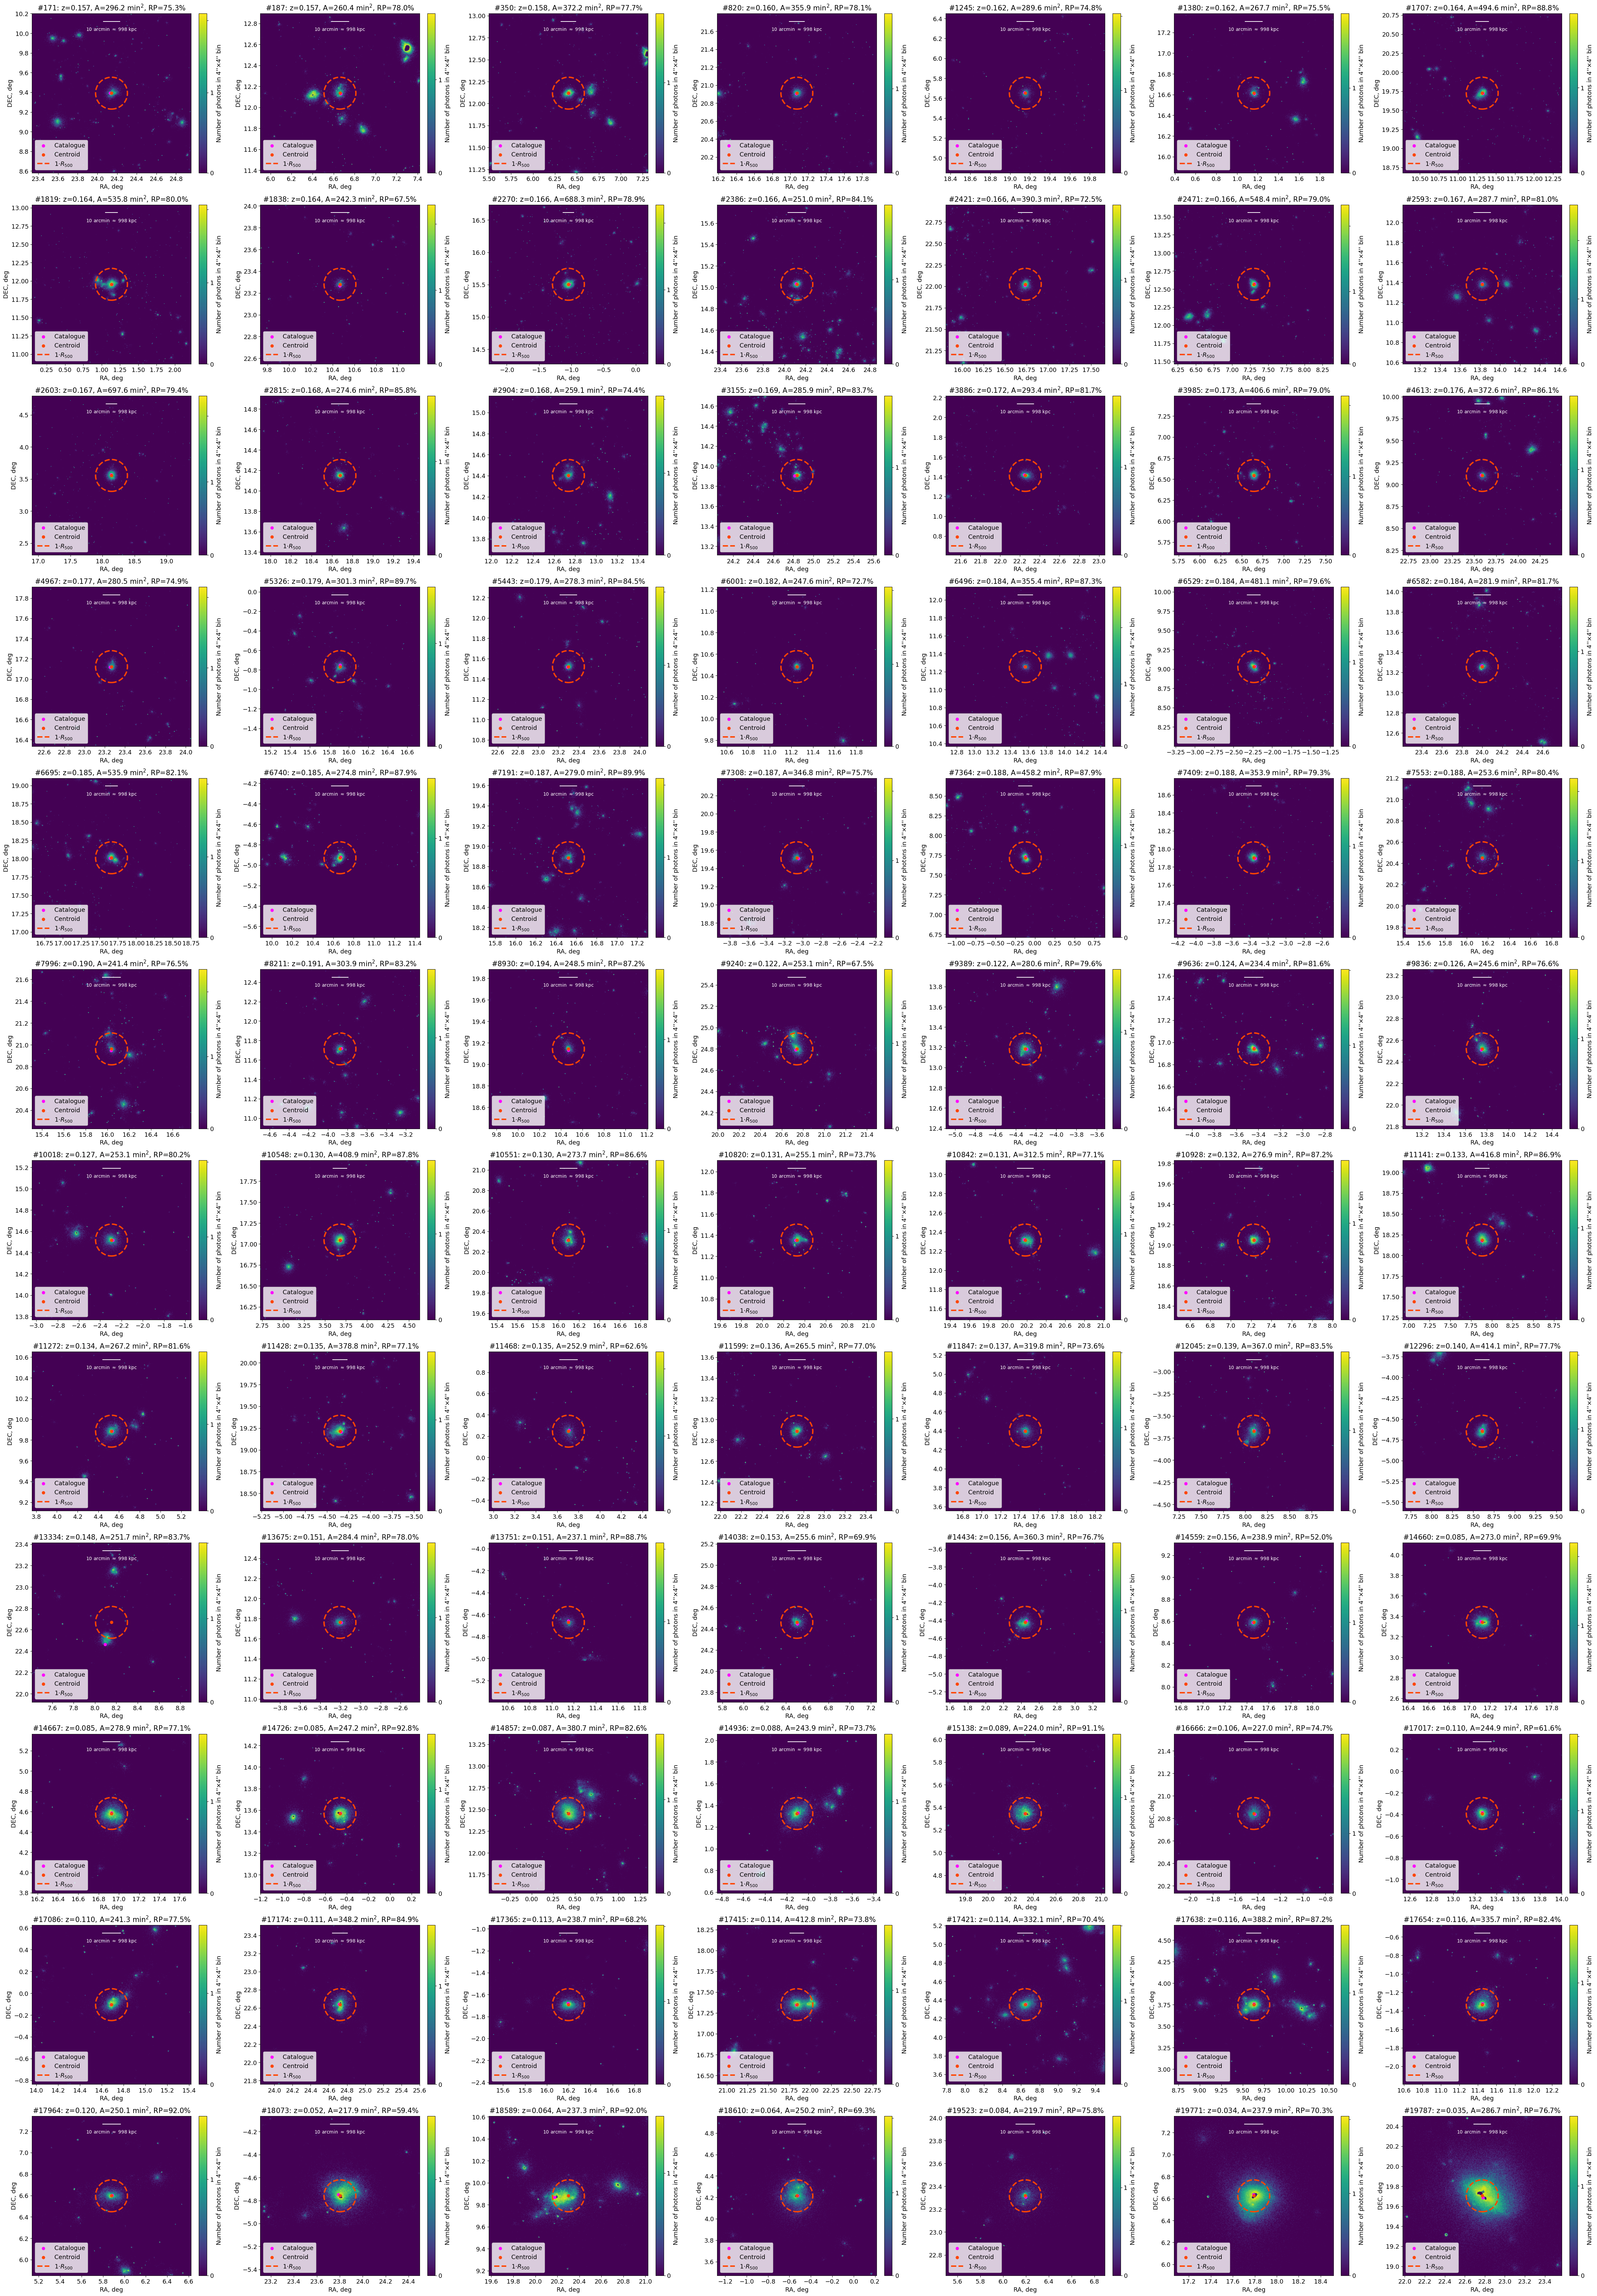

In [20]:
%run -i 'scripts.py'

draw_84_panels(mode='IMAGE')

plt.savefig('panels_filtered.png', format='png', dpi=200, bbox_inches='tight')

plt.show()